In [1]:
import sys
sys.path.append("../../src/other_methods/DoublyRobustPCL")
sys.path.append("../..")

import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
from utils.data_class import PVTrainDataSet,PVTestDataSet
from model.rkhs.Trainer import RKHS_Trainer
from src.generate_experiment_data import generate_synthetic_data
from src.utils.ml_utils import data_transform

In [2]:
cfg = "../../src/other_methods/DoublyRobustPCL/config/job/train/default.yaml"

with open(cfg) as stream:
    try:
        cfg = yaml.safe_load(stream)
        # print(yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

class obj(object):
    def __init__(self, d):
        for k, v in d.items():
            if isinstance(k, (list, tuple)):
                setattr(self, k, [obj(x) if isinstance(x, dict) else x for x in v])
            else:
                setattr(self, k, obj(v) if isinstance(v, dict) else v)

cfg = obj(cfg)

In [3]:
data_size = 1000
test_data_size = 1000
seed = np.random.randint(1000000)
np.random.seed(seed)

U, W, Z, A, Y, do_A, EY_do_A = generate_synthetic_data(size = data_size, seed = seed, do_A_range = (-1, 2))

# train_dataset = PVTrainDataSet( treatment = A,
#                                 treatment_proxy = Z,
#                                 outcome_proxy = W,
#                                 outcome = Y,
#                                 backdoor = None)

_, W_test, Z_test, A_test, Y_test, *_ = generate_synthetic_data(size = test_data_size, seed = seed + 1)

# test_dataset = PVTrainDataSet(  treatment = A_test,
#                                 treatment_proxy = Z_test,
#                                 outcome_proxy = W_test,
#                                 outcome = Y_test,
#                                 backdoor = None)


A_transformed, A_transformer = data_transform(A)
Z_transformed, Z_transformer = data_transform(Z)
W_transformed, W_transformer = data_transform(W)
Y_transformed, Y_transformer = data_transform(Y)

data_size = A_transformed.shape[0]
A_transformed = np.array(A_transformed).reshape(data_size, -1)
Z_transformed = np.array(Z_transformed).reshape(data_size, -1)
W_transformed = np.array(W_transformed).reshape(data_size, -1)
Y_transformed = np.array(Y_transformed).reshape(data_size, -1)

train_dataset = PVTrainDataSet( treatment = A_transformed,
                                treatment_proxy = Z_transformed,
                                outcome_proxy = W_transformed,
                                outcome = Y_transformed,
                                backdoor = None)

A_test_transformed = A_transformer.transform(A_test).reshape(test_data_size, -1)
Z_test_transformed = Z_transformer.transform(Z_test).reshape(test_data_size, -1)
W_test_transformed = W_transformer.transform(W_test).reshape(test_data_size, -1)
Y_test_transformed = Y_transformer.transform(Y_test).reshape(test_data_size, -1)

test_dataset = PVTrainDataSet(  treatment = A_test_transformed,
                                treatment_proxy = Z_test_transformed,
                                outcome_proxy = W_test_transformed,
                                outcome = Y_test_transformed,
                                backdoor = None)

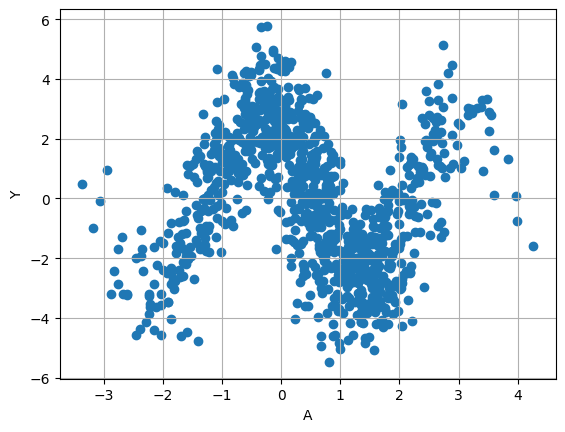

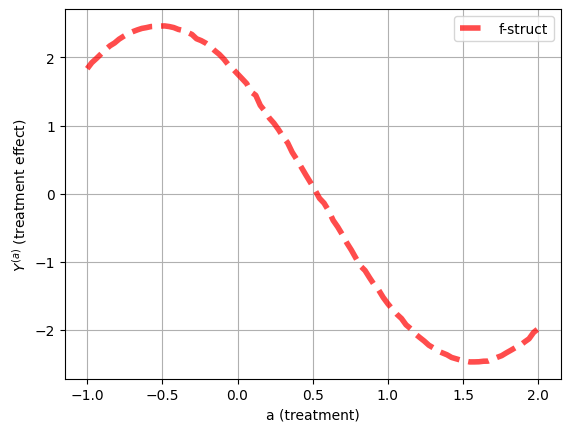

In [4]:
plt.scatter(A, Y)
plt.xlabel("A")
plt.ylabel("Y")
plt.grid()
plt.show()


plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha=0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()

Structured function test set MSE: 0.13577686634679334
Structured function test set MAE: 0.3383457079282449


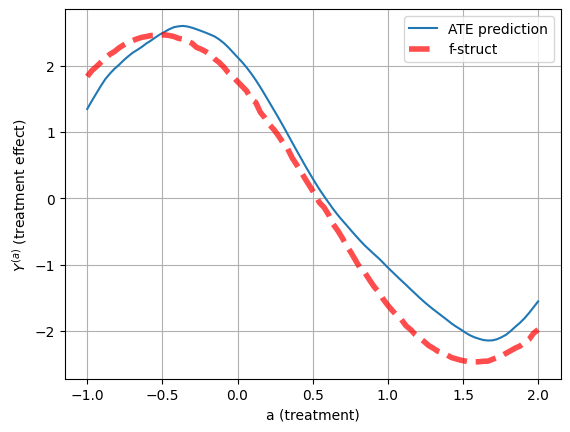

In [5]:
rkhs_train = RKHS_Trainer(cfg, train_dataset)

# Train q
rkhs_train.fit_q_cv()
do_A_size = do_A.shape[0]
do_A_transformed = (A_transformer.transform(do_A)).reshape(do_A_size, -1)
ATE_q_transformed = rkhs_train._qtest(do_A_transformed, test_dataset)
f_struct_pred = Y_transformer.inverse_transform(np.array(ATE_q_transformed).reshape(-1, 1))
structured_pred_mse = (np.mean((f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1)) ** 2))
structured_pred_mae = (np.mean(np.abs(f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1))))

print("Structured function test set MSE: {}".format(structured_pred_mse))
print("Structured function test set MAE: {}".format(structured_pred_mae))

plt.plot(do_A, f_struct_pred, label = "ATE prediction")
plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha = 0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()
plt.show()